In [1]:
# dependencies
import os
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import seaborn as sns

sns.set()
sns.set_style("dark")
# sns.set_style("whitegrid")
sns.set_context("paper", font_scale=4, rc={"lines.linewidth": 4})
mpl.rcParams['lines.linewidth'] = 3

In [2]:
import pyvista as pv
import geopandas as gpd
from shapely.geometry import Point
from descartes import PolygonPatch

In [3]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [4]:
import random
import datetime

# Get district data

In [5]:
sys.path.insert(0, '../county_data')
from read_county_data import *

In [6]:
sys.path.insert(1, '../district_data')
from read_district_data import *

In [7]:
# get county data
county_nms, county_dist, county_dist_names, county_polys = read_county_map('../county_data/data/')
N_counties = len(county_nms)

In [8]:
# get district data
new_dist_nm, new_dist_county_nbr, new_dist_county_nm, new_dist_geom = read_dist_map('../district_data/data/', county_nms, county_dist, 
                                                  county_dist_names, county_polys, 0)
N_districts = len(new_dist_nm)

In [9]:
for i in range(len(county_nms)):
    print('{0:<16} {1:<10}'.format(county_nms[i], i))

Anderson         0         
Andrews          1         
Angelina         2         
Aransas          3         
Archer           4         
Armstrong        5         
Atascosa         6         
Austin           7         
Bailey           8         
Bandera          9         
Bastrop          10        
Baylor           11        
Bee              12        
Bell             13        
Bexar            14        
Blanco           15        
Borden           16        
Bosque           17        
Bowie            18        
Brazoria         19        
Brazos           20        
Brewster         21        
Briscoe          22        
Brooks           23        
Brown            24        
Burleson         25        
Burnet           26        
Caldwell         27        
Calhoun          28        
Callahan         29        
Cameron          30        
Camp             31        
Carson           32        
Cass             33        
Castro           34        
Chambers         35 

In [10]:
def find_county_id(nm):
    for i in range(N_counties):
        if nm == county_nms[i]:
            return i
            

# Read COVID-19 data

We need to first process data taking care of following issues:

- Data at following dates are missing: 7,8,14 March. Add values for these dates by copying the values of previous dates.

- Cases only start from 6 March 2020. Start data from this date.

In [11]:
data_path = 'Data_25June2020/'
infected_total_cases_data = pd.read_csv(data_path + 'infected_total.csv')
infected_total_cases_data = infected_total_cases_data.T
infected_total_cases_data

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
0,1,2,3,4,5,6,7,8,9,10,...,246,247,248,249,250,251,252,253,254,255
1,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala,Total
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1006,44,380,7,3,3,70,45,83,15,...,1237,72,6,62,71,13,16,33,13,111601
109,1006,44,380,7,3,3,70,48,86,15,...,1337,72,6,62,71,13,16,33,13,114881
110,1009,44,415,10,4,3,79,56,88,16,...,1411,76,6,63,76,15,17,40,14,120370
111,1013,46,426,10,5,3,84,57,86,15,...,1498,80,8,88,77,15,22,40,16,125921


In [12]:
deceased_cases_data = pd.read_csv(data_path + 'deceased.csv')
deceased_cases_data = deceased_cases_data.T
deceased_cases_data

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
0,1,2,3,4,5,6,7,8,9,10,...,246,247,248,249,250,251,252,253,254,255
1,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala,Total
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2,0,6,0,0,0,2,0,0,0,...,32,5,0,5,5,0,1,0,0,2182
112,2,0,6,0,0,0,2,0,0,0,...,32,5,0,5,5,0,1,0,0,2192
113,2,0,6,0,0,0,2,0,1,0,...,32,5,0,5,5,0,1,0,0,2220
114,2,0,6,0,0,0,2,0,1,0,...,32,5,0,5,5,0,1,0,0,2249


In [13]:
infected_active_cases_data = pd.read_csv(data_path + 'infected_active.csv')
infected_active_cases_data = infected_active_cases_data.T
infected_active_cases_data

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,1,2,3,4,5,6,7,8,9,10,...,245,246,247,248,249,250,251,252,253,254
1,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala
2,1,10,14,1,0,0,4,6,0,0,...,4,67,7,0,3,4,0,3,1,0
3,1,10,14,2,0,0,3,6,0,0,...,6,68,7,0,3,4,0,3,1,0
4,2,10,14,2,0,0,3,6,0,1,...,4,75,8,0,3,4,0,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,924,12,190,2,1,0,30,5,5,9,...,50,471,26,3,11,26,10,10,22,2
77,924,14,190,2,1,0,30,5,5,9,...,53,533,29,3,11,26,10,10,22,1
78,923,14,149,2,1,0,29,5,5,9,...,59,607,28,3,11,26,10,10,22,1
79,921,14,184,5,1,0,38,5,5,10,...,65,657,32,3,11,29,10,11,29,2


In [14]:
# list(infected_cases_data.columns)
# list(infected_cases_data.index)

In [15]:
infected_total_cases_data[254][1]

'Total'

In [16]:
COUNTY_NAME_ROW_INDEX = 1
CASES_START_ROW_INDEX = 2
INFECTED_TOTAL_CASES_START_ROW_INDEX = 2
INFECTED_TOTAL_TEXAS_CASES_COL_INDEX = 254

INFECTED_TOTAL_FIRST_DAYS_IGNORE = 2
INFECTED_TOTAL_DAY_BEGIN = [6, 3, 2020]
INFECTED_ACTIVE_DAY_BEGIN = [7, 4, 2020]

In [17]:
INFECTED_TOTAL_DATA_TOTAL_DAYS = len(infected_total_cases_data[0]) - CASES_START_ROW_INDEX \
                                - INFECTED_TOTAL_FIRST_DAYS_IGNORE + 3 # add missing days
print(INFECTED_TOTAL_DATA_TOTAL_DAYS)

112


In [18]:
INFECTED_ACTIVE_DATA_TOTAL_DAYS = len(infected_active_cases_data[0]) - CASES_START_ROW_INDEX
print(INFECTED_ACTIVE_DATA_TOTAL_DAYS)

79


In [19]:
DECEASED_DATA_TOTAL_DAYS = len(deceased_cases_data[0]) - CASES_START_ROW_INDEX \
                            - INFECTED_TOTAL_FIRST_DAYS_IGNORE
print(DECEASED_DATA_TOTAL_DAYS)

112


In [20]:
DATA_TOTAL_DAYS = INFECTED_TOTAL_DATA_TOTAL_DAYS
DATA_DAY_BEGIN = INFECTED_TOTAL_DAY_BEGIN
# print(DATA_TOTAL_DAYS)

In [21]:
# list(covid_data.columns)
covid_data_county_nms = [infected_total_cases_data[i][COUNTY_NAME_ROW_INDEX] for i in range(N_counties)]
covid_data_county_nbr = [0 for i in range(N_counties)]
for i in range(N_counties):
    nm = infected_total_cases_data[i][COUNTY_NAME_ROW_INDEX]
    covid_data_county_nbr[i] = find_county_id(nm)
            
for i in range(N_counties):
    print('col id: {0: <6} col name: {1: <16} county nbr: {2: <6} county nm: {3: <16} match: {4}'.format(i, 
            covid_data_county_nms[i], covid_data_county_nbr[i], 
            county_nms[covid_data_county_nbr[i]], county_nms[i] == covid_data_county_nms[i]))
    
    

col id: 0      col name: Anderson         county nbr: 0      county nm: Anderson         match: True
col id: 1      col name: Andrews          county nbr: 1      county nm: Andrews          match: True
col id: 2      col name: Angelina         county nbr: 2      county nm: Angelina         match: True
col id: 3      col name: Aransas          county nbr: 3      county nm: Aransas          match: True
col id: 4      col name: Archer           county nbr: 4      county nm: Archer           match: True
col id: 5      col name: Armstrong        county nbr: 5      county nm: Armstrong        match: True
col id: 6      col name: Atascosa         county nbr: 6      county nm: Atascosa         match: True
col id: 7      col name: Austin           county nbr: 7      county nm: Austin           match: True
col id: 8      col name: Bailey           county nbr: 8      county nm: Bailey           match: True
col id: 9      col name: Bandera          county nbr: 9      county nm: Bandera          ma

# map COVID-19 data so that county numbering is consistent with the map

In [22]:
# Get all cases
infected_total_cases = []
total_data_days = len(infected_total_cases_data[0]) - CASES_START_ROW_INDEX
for i in range(total_data_days):
    d = []
    for j in range(N_counties):
        d.append(infected_total_cases_data[j][i+CASES_START_ROW_INDEX])
    infected_total_cases.append(d)
    
infected_total_cases = np.array(infected_total_cases)
# np.savetxt(data_path + 'infected_total_processed_try.txt', infected_total_cases)

In [23]:
# we now remove first 2 days from the data
infected_total_cases = infected_total_cases[INFECTED_TOTAL_FIRST_DAYS_IGNORE:, :]

In [24]:
# Get all cases
deceased_cases = []
total_data_days = len(deceased_cases_data[0]) - CASES_START_ROW_INDEX
for i in range(total_data_days):
    d = []
    for j in range(N_counties):
        d.append(deceased_cases_data[j][i+CASES_START_ROW_INDEX])
    deceased_cases.append(d)
    
deceased_cases = np.array(deceased_cases)
# np.savetxt(data_path + 'deceased_processed_try.txt', deceased_cases)

In [25]:
# we now remove first 2 days from the data
deceased_cases = deceased_cases[INFECTED_TOTAL_FIRST_DAYS_IGNORE:, :]

In [26]:
# insert missing data on 7,8,14 March
march_7_insert_index = 1    # 7 - 6 = 1
march_8_insert_index = 2    # 8 - 6 = 2 
march_14_insert_index = 8   # 14 - 6 = 8

print('size: {}'.format(infected_total_cases.shape))

infected_total_cases = np.insert(infected_total_cases, march_7_insert_index, infected_total_cases[march_7_insert_index-1, :], 0)
print('New size: {}'.format(infected_total_cases.shape))
print('Copied data: {}'.format(infected_total_cases[march_7_insert_index-1, :]))
print('Added data: {}'.format(infected_total_cases[march_7_insert_index, :]))

infected_total_cases = np.insert(infected_total_cases, march_8_insert_index, infected_total_cases[march_8_insert_index-1, :], 0)
print('New size: {}'.format(infected_total_cases.shape))
print('Copied data: {}'.format(infected_total_cases[march_8_insert_index-1, :]))
print('Added data: {}'.format(infected_total_cases[march_8_insert_index, :]))

infected_total_cases = np.insert(infected_total_cases, march_14_insert_index, infected_total_cases[march_14_insert_index-1, :], 0)
print('New size: {}'.format(infected_total_cases.shape))
print('Copied data: {}'.format(infected_total_cases[march_14_insert_index-1, :]))
print('Added data: {}'.format(infected_total_cases[march_14_insert_index, :]))

size: (109, 254)
New size: (110, 254)
Copied data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Added data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [27]:
print('Expected size: {0: <16} Original size infected: {1: <16} Original size deceased: \
      {2}'.format(DATA_TOTAL_DAYS, \
      len(infected_total_cases), len(deceased_cases)))

Expected size: 112              Original size infected: 112              Original size deceased:       112


In [28]:
# Get infected active cases
# first read the data given
temp_cases = []
total_data_days = len(infected_active_cases_data[0]) - CASES_START_ROW_INDEX
for i in range(total_data_days):
    d = []
    for j in range(N_counties):
        d.append(infected_active_cases_data[j][i+CASES_START_ROW_INDEX])
    temp_cases.append(d)
    
print(len(temp_cases))

79


In [29]:
# now create a array of same size as infected_total and deceased cases and for entries before
# April 7, enter infected total cases and after April 7 use the active cases data
infected_active_cases = []
for i in range(DATA_TOTAL_DAYS):
    d = []
    
    if i < DATA_TOTAL_DAYS - INFECTED_ACTIVE_DATA_TOTAL_DAYS:
        d = infected_total_cases[i] - deceased_cases[i]
    else:
        d = temp_cases[i - INFECTED_ACTIVE_DATA_TOTAL_DAYS]
    infected_active_cases.append(d)
    
infected_active_cases = np.array(infected_active_cases)
np.savetxt(data_path + 'infected_active_processed_try.txt', infected_active_cases)

In [30]:
print('Expected size: {0:<10} infected total: {1: <2} \
        infected active: {2: <2} \
        deceased: {3}'.format(DATA_TOTAL_DAYS, \
          len(infected_total_cases), len(infected_active_cases), len(deceased_cases)))

Expected size: 112        infected total: 112         infected active: 112         deceased: 112


In [31]:
# np.savetxt(data_path + 'infected_processed_try2.txt', infected_cases)
# np.savetxt(data_path + 'deceased_processed_try2.txt', deceased_cases)

## Map which takes order of county names in covid data to order of county names in shapefile

In [32]:
# use covid_data_county_nbr to map column number i to county number 

In [33]:
county_infected_total_cases = [[0 for i in range(N_counties)] for j in range(DATA_TOTAL_DAYS)]
county_infected_active_cases = [[0 for i in range(N_counties)] for j in range(DATA_TOTAL_DAYS)]
county_deceased_cases = [[0 for i in range(N_counties)] for j in range(DATA_TOTAL_DAYS)]
county_recovered_cases = [[0 for i in range(N_counties)] for j in range(DATA_TOTAL_DAYS)]

for i in range(DATA_TOTAL_DAYS):
    for j in range(N_counties):
        county_infected_total_cases[i][covid_data_county_nbr[j]] = infected_total_cases[i][j]
        county_infected_active_cases[i][covid_data_county_nbr[j]] = infected_active_cases[i][j]
        county_deceased_cases[i][covid_data_county_nbr[j]] = deceased_cases[i][j]
        a = infected_total_cases[i][j] - deceased_cases[i][j] - infected_active_cases[i][j]
        if a < 0.:
            a = 0.
        county_recovered_cases[i][covid_data_county_nbr[j]] = a

In [34]:
np.savetxt(data_path + 'processed/infected_total_county.txt', county_infected_total_cases)
np.savetxt(data_path + 'processed/infected_active_county.txt', county_infected_active_cases)
np.savetxt(data_path + 'processed/deceased_county.txt', county_deceased_cases)
np.savetxt(data_path + 'processed/recovered_county.txt', county_recovered_cases)

In [35]:
covid_data_t = [i for i in range(DATA_TOTAL_DAYS)]
date_start = datetime.datetime(year = DATA_DAY_BEGIN[2], month=DATA_DAY_BEGIN[1], day = DATA_DAY_BEGIN[0])
covid_data_tdate = [date_start + datetime.timedelta(days=i) for i in range(DATA_TOTAL_DAYS)]
for i in range(DATA_TOTAL_DAYS):
    if i % 5 == 0:
        print('t: {0:<16} date: {1}'.format(covid_data_t[i], covid_data_tdate[i].date()))
        
fp = open(data_path + 'processed/cases_date.txt', 'w')
for i in range(DATA_TOTAL_DAYS):
    fp.write('{}\n'.format(covid_data_tdate[i].date()))
fp.close()

t: 0                date: 2020-03-06
t: 5                date: 2020-03-11
t: 10               date: 2020-03-16
t: 15               date: 2020-03-21
t: 20               date: 2020-03-26
t: 25               date: 2020-03-31
t: 30               date: 2020-04-05
t: 35               date: 2020-04-10
t: 40               date: 2020-04-15
t: 45               date: 2020-04-20
t: 50               date: 2020-04-25
t: 55               date: 2020-04-30
t: 60               date: 2020-05-05
t: 65               date: 2020-05-10
t: 70               date: 2020-05-15
t: 75               date: 2020-05-20
t: 80               date: 2020-05-25
t: 85               date: 2020-05-30
t: 90               date: 2020-06-04
t: 95               date: 2020-06-09
t: 100              date: 2020-06-14
t: 105              date: 2020-06-19
t: 110              date: 2020-06-24


# Compute district data from county data

In [36]:
dist_infected_total_cases = [[0 for i in range(N_districts)] for j in range(DATA_TOTAL_DAYS)]
dist_infected_active_cases = [[0 for i in range(N_districts)] for j in range(DATA_TOTAL_DAYS)]
dist_deceased_cases = [[0 for i in range(N_districts)] for j in range(DATA_TOTAL_DAYS)]
dist_recovered_cases = [[0 for i in range(N_districts)] for j in range(DATA_TOTAL_DAYS)]
for j in range(DATA_TOTAL_DAYS):
    for i in range(N_districts):
        for k in new_dist_county_nbr[i]:
            dist_infected_total_cases[j][i] += county_infected_total_cases[j][k]
            dist_infected_active_cases[j][i] += county_infected_active_cases[j][k]
            dist_deceased_cases[j][i] += county_deceased_cases[j][k]
            dist_recovered_cases[j][i] += county_recovered_cases[j][k]
        
# prepare a csv file for data
np.savetxt(data_path + 'processed/infected_total_district.txt', dist_infected_total_cases)
np.savetxt(data_path + 'processed/infected_active_district.txt', dist_infected_active_cases)
np.savetxt(data_path + 'processed/deceased_district.txt', dist_deceased_cases)
np.savetxt(data_path + 'processed/recovered_district.txt', dist_recovered_cases)

# Compute total cases in Texas

In [37]:
state_infected_total_cases = [0 for i in range(DATA_TOTAL_DAYS)]
state_infected_active_cases = [0 for i in range(DATA_TOTAL_DAYS)]
state_deceased_cases = [0 for i in range(DATA_TOTAL_DAYS)]
state_recovered_cases = [0 for i in range(DATA_TOTAL_DAYS)]
for i in range(DATA_TOTAL_DAYS):
    
    for j in range(N_districts):
        state_infected_total_cases[i] += dist_infected_total_cases[i][j]
        state_infected_active_cases[i] += dist_infected_active_cases[i][j]
        state_deceased_cases[i] += dist_deceased_cases[i][j]
        state_recovered_cases[i] += dist_recovered_cases[i][j]

In [38]:
# prepare a csv file for data
np.savetxt(data_path + 'processed/infected_total_state.txt', state_infected_total_cases)
np.savetxt(data_path + 'processed/infected_active_state.txt', state_infected_active_cases)
np.savetxt(data_path + 'processed/deceased_state.txt', state_deceased_cases)
np.savetxt(data_path + 'processed/recovered_state.txt', state_recovered_cases)

# Plot district data

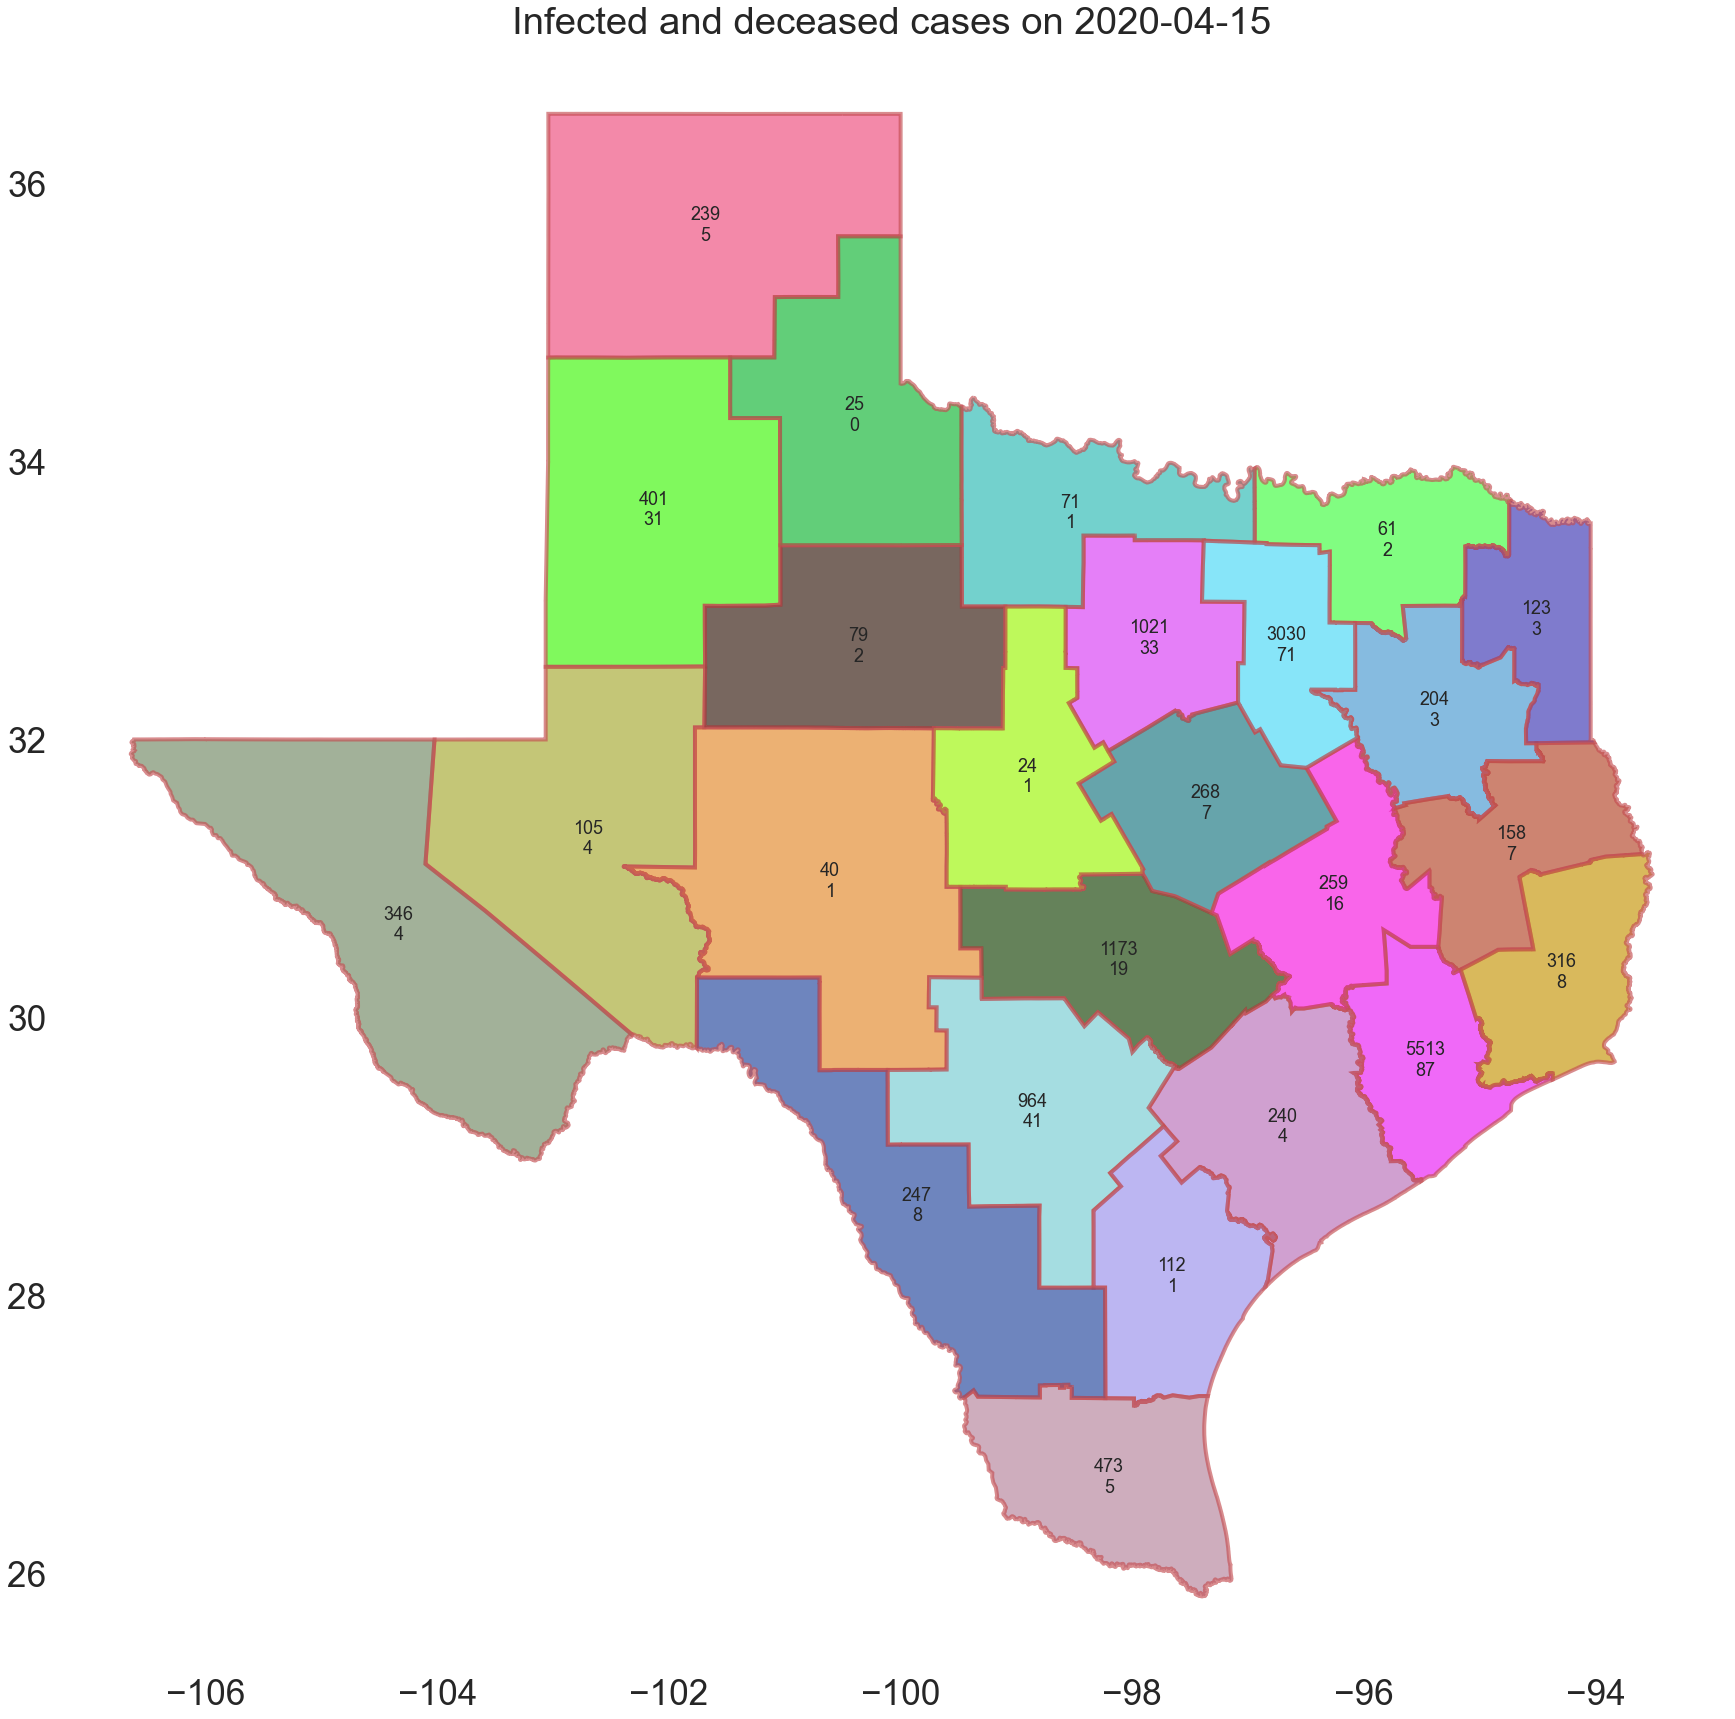

In [39]:
fig = plt.figure(figsize=(30, 30))
# plt.axis([x_min, x_max, y_min, y_max])
plt.autoscale(enable=True, axis='both')
plt.gca().set_facecolor("white")

data_view_t = 40
        
def plot_dist():
    ax = fig.gca() 
    for i in range(len(new_dist_geom)):
        poly = new_dist_geom[i]
        ax.add_patch(PolygonPatch(poly, fill=True, fc=np.random.rand(3,), ec='r',  
                                  alpha=0.65, zorder=2, linewidth=4))
        plt.text(poly.centroid.xy[0][0], poly.centroid.xy[1][0], 
                 str(dist_infected_total_cases[data_view_t][i])  
                 + '\n' + str(dist_deceased_cases[data_view_t][i]),
                 ha='center', va='center', fontsize='18')
    


# plot_tri()
plot_dist()
plt.title('Infected and deceased cases on {}'.format(covid_data_tdate[data_view_t].date()))
# plt.savefig('plot_district_simple_cases_{}_{}.pdf'.format(covid_data_tdate[data_view_t].date(), mesh_fname))
plt.show()

# Plot county data

Text(0.5, 1.0, 'Infected and deceased cases on 2020-04-15')

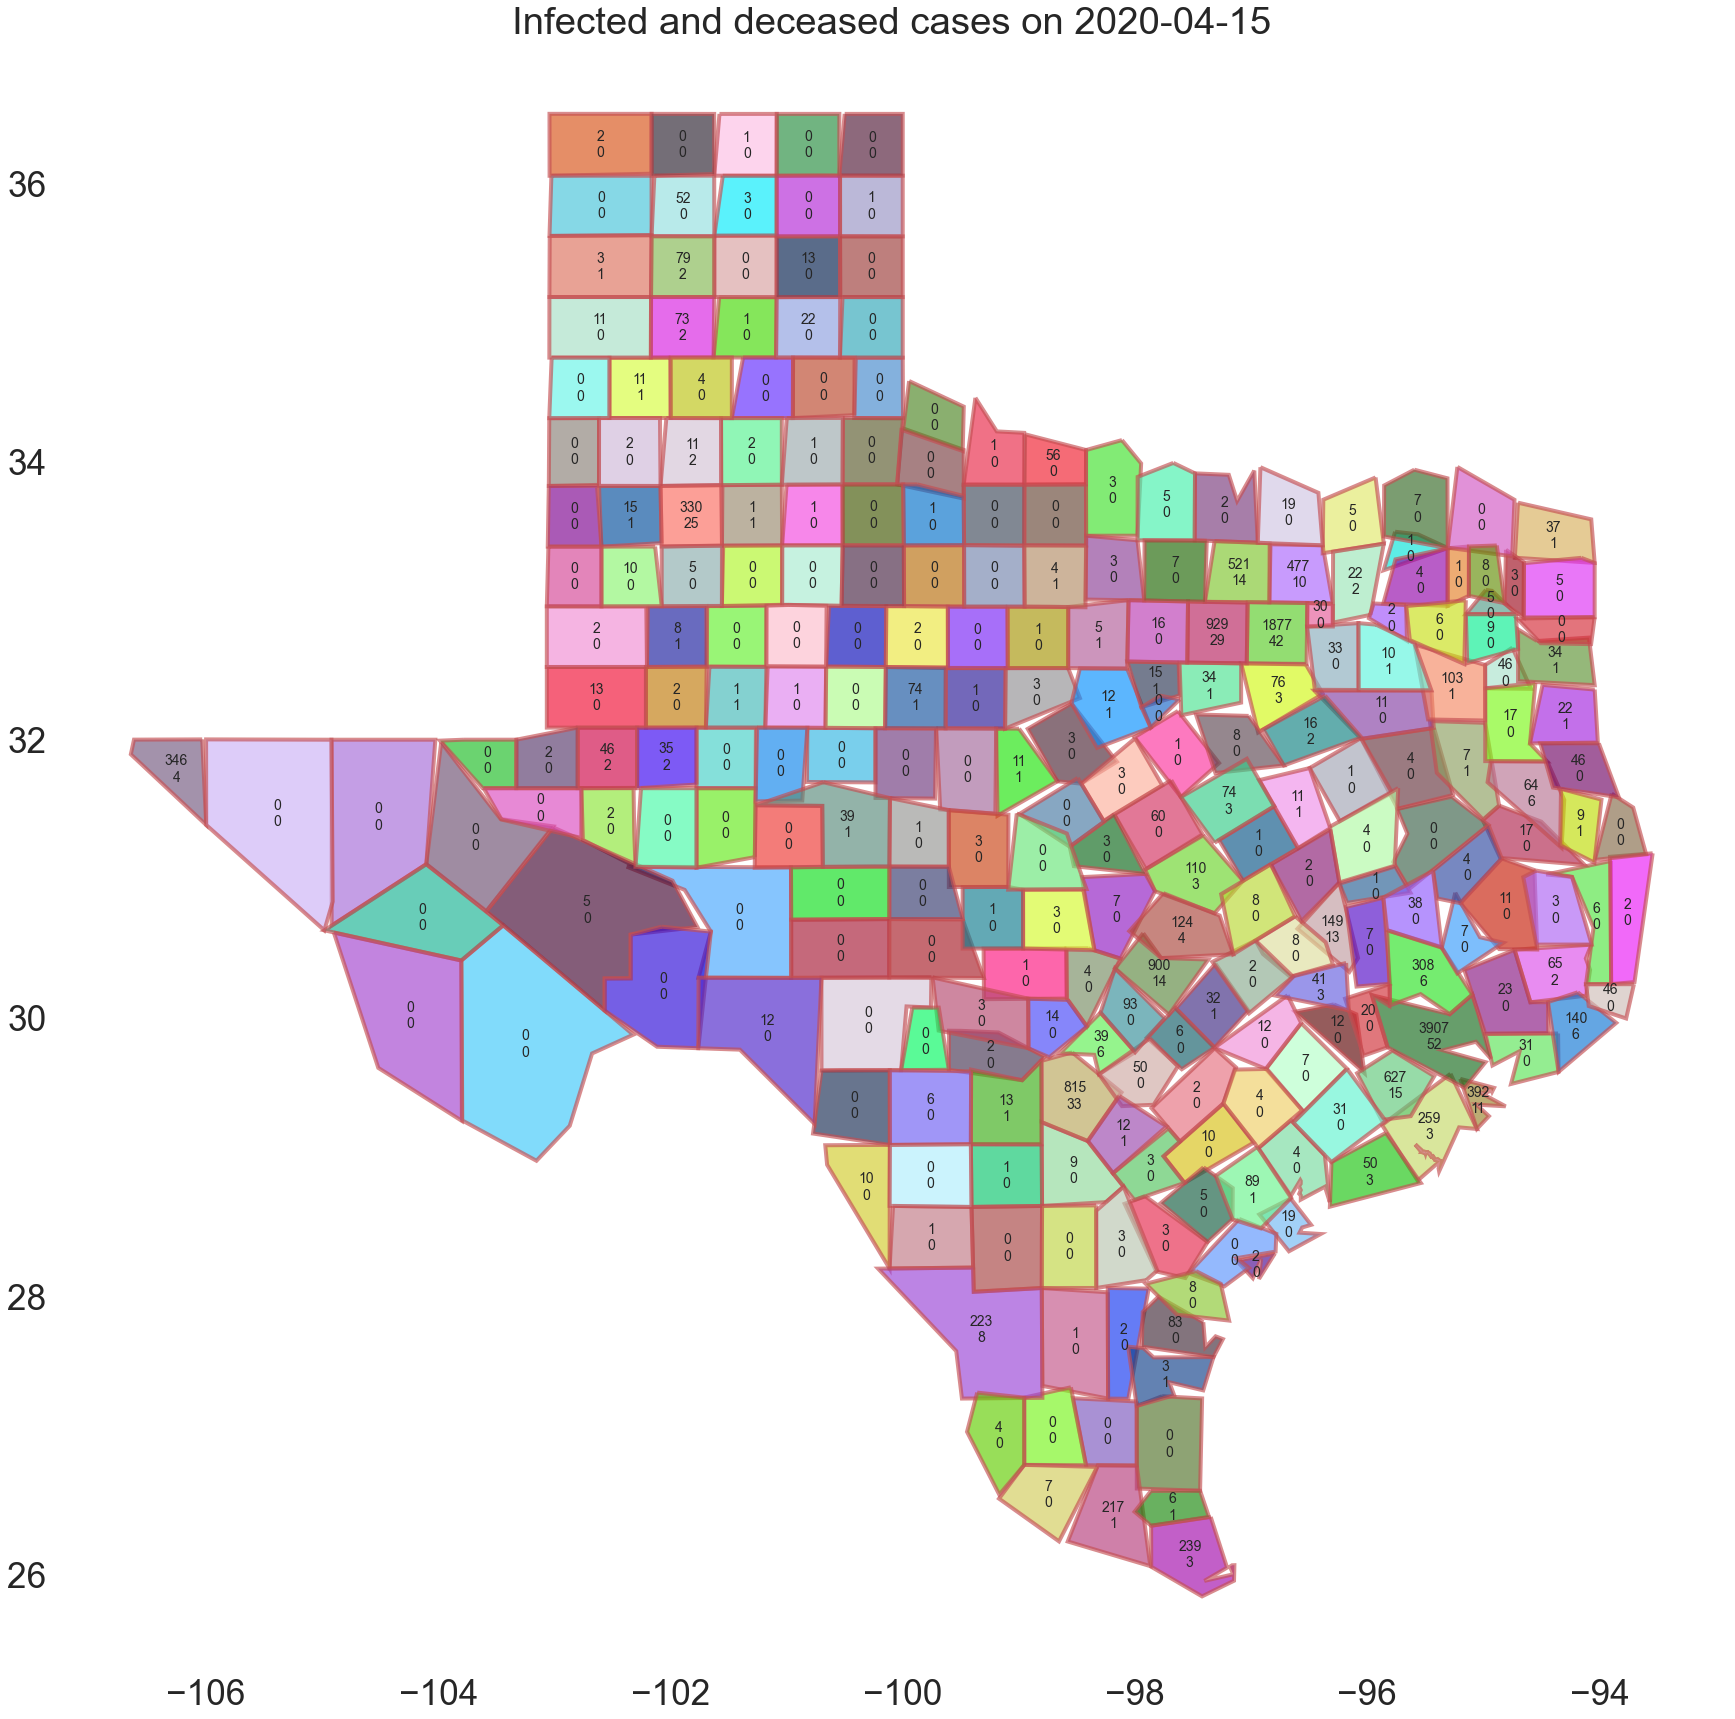

In [40]:
fig = plt.figure(figsize=(30, 30))
# plt.axis([x_min, x_max, y_min, y_max])
plt.autoscale(enable=True, axis='both')
plt.gca().set_facecolor("white")

data_view_t = 40
        
def plot_county():
    ax = fig.gca() 
    for i in range(len(county_polys)):
        poly = county_polys[i][0]
        ax.add_patch(PolygonPatch(poly, fill=True, fc=np.random.rand(3,), 
                                  ec='r', alpha=0.65, zorder=2, linewidth=4))
        plt.text(poly.centroid.xy[0][0], poly.centroid.xy[1][0], 
                 str(county_infected_total_cases[data_view_t][i]) 
                 + '\n' + str(county_deceased_cases[data_view_t][i]), 
                 ha='center', va='center', fontsize='14')
    


# plot_tri()
plot_county()
plt.title('Infected and deceased cases on {}'.format(covid_data_tdate[data_view_t].date()))
# plt.savefig('plot_district_simple_cases_{}_{}.pdf'.format(covid_data_tdate[data_view_t].date(), mesh_fname))

Text(0.5, 1.0, 'Infected and deceased cases on 2020-04-15')

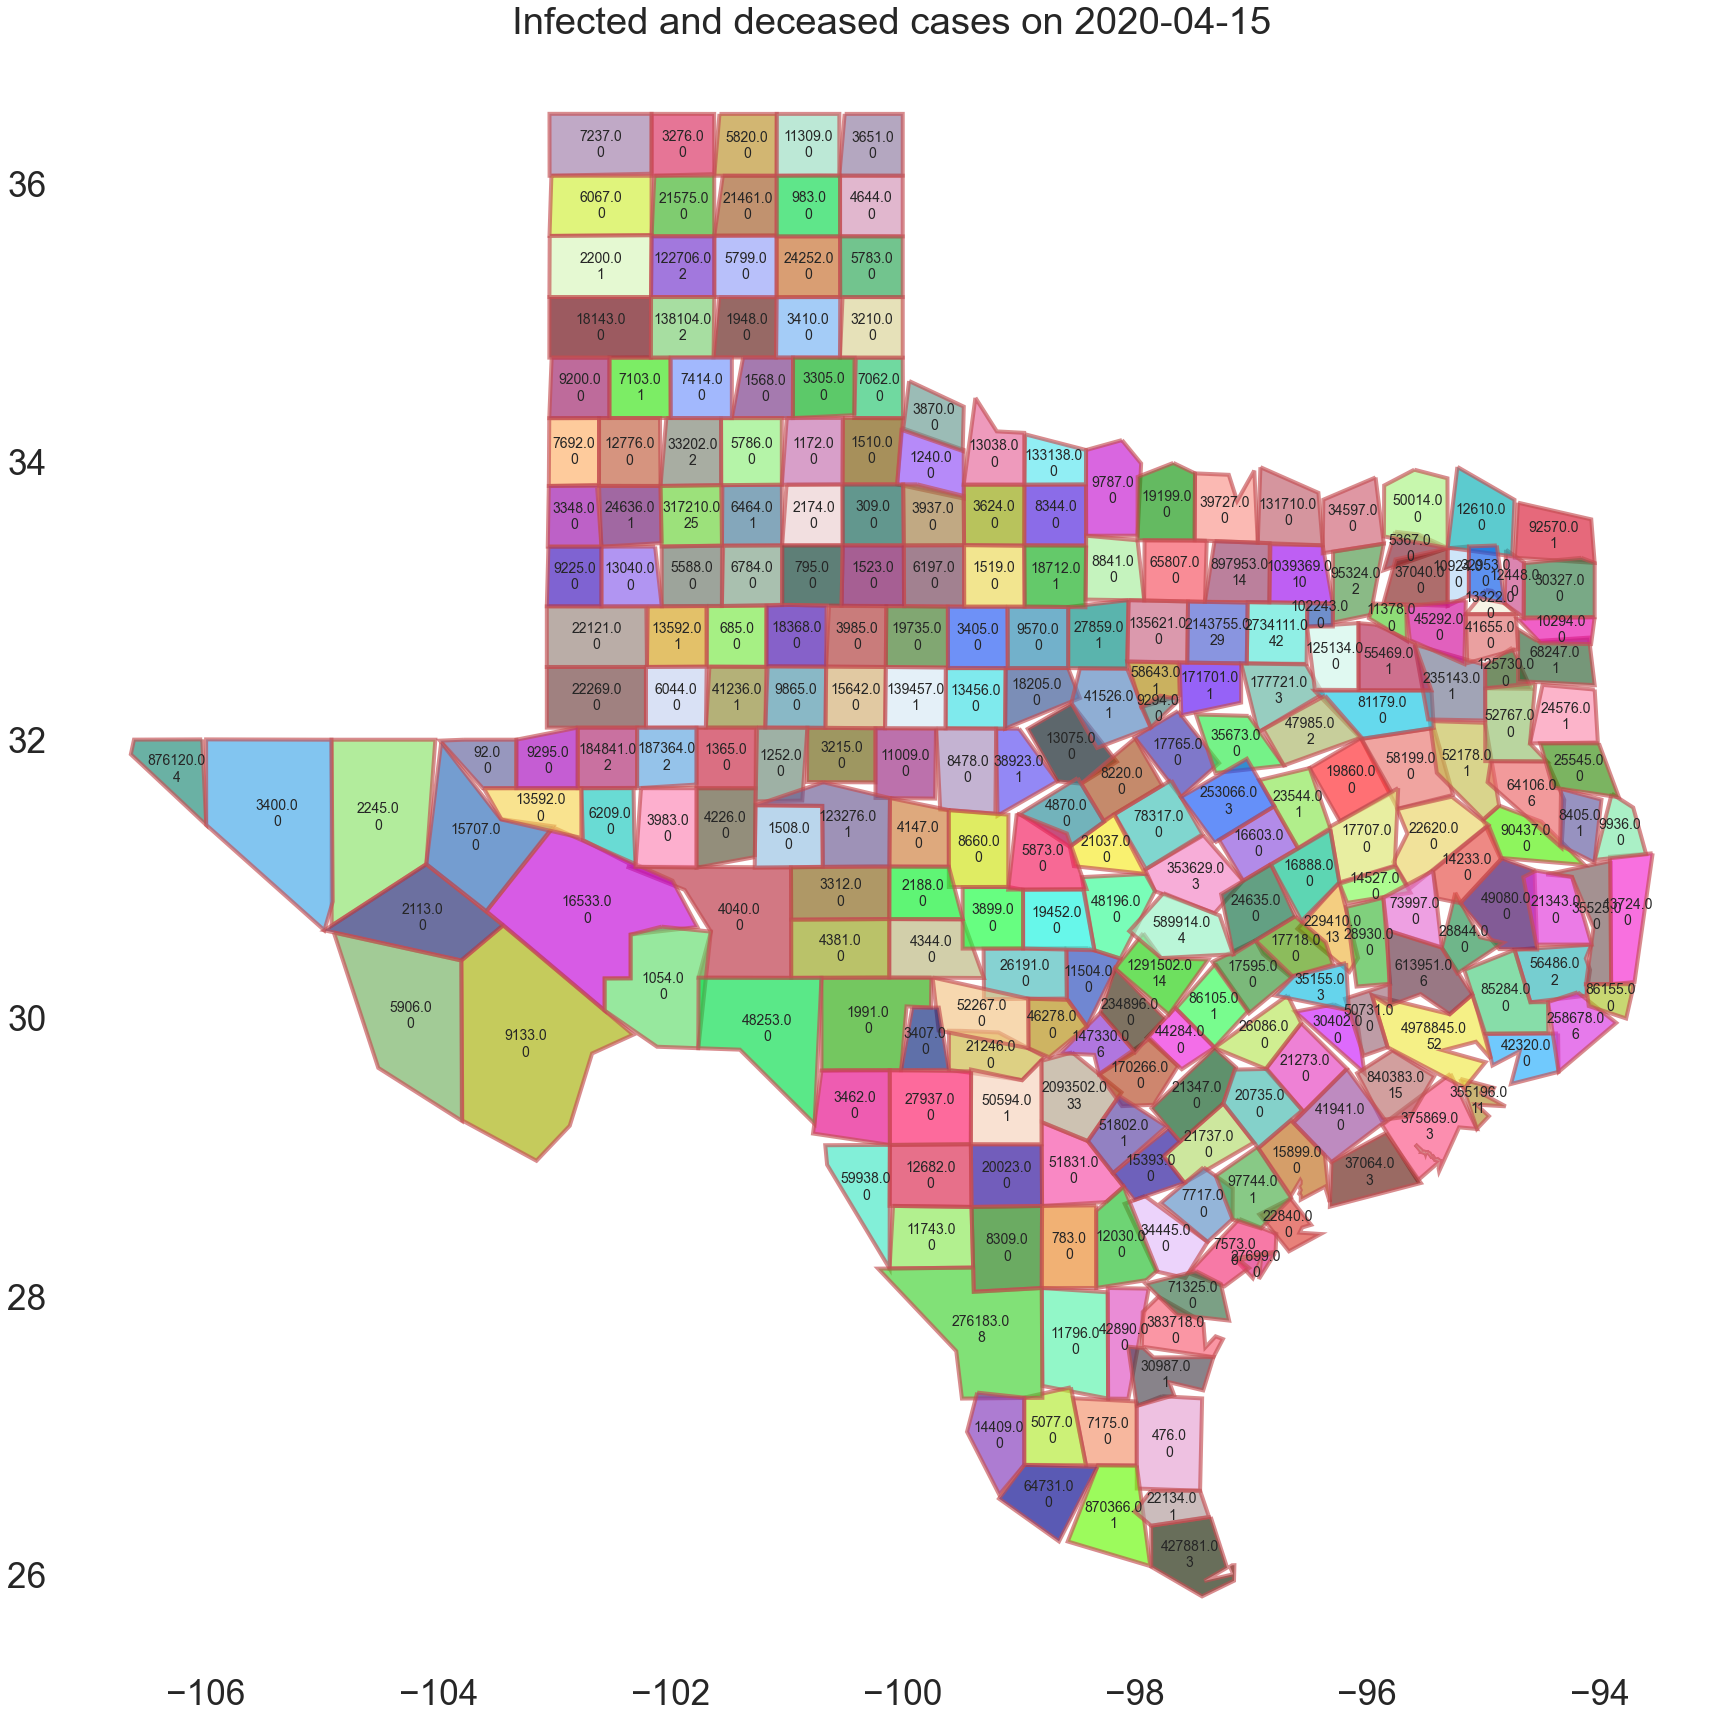

In [41]:
fig = plt.figure(figsize=(30, 30))
# plt.axis([x_min, x_max, y_min, y_max])
plt.autoscale(enable=True, axis='both')
plt.gca().set_facecolor("white")

data_view_t = 40

county_population = np.loadtxt('county_population.txt')
        
def plot_county():
    ax = fig.gca() 
    for i in range(len(county_polys)):
        poly = county_polys[i][0]
        ax.add_patch(PolygonPatch(poly, fill=True, fc=np.random.rand(3,), 
                                  ec='r', alpha=0.65, zorder=2, linewidth=4))
        plt.text(poly.centroid.xy[0][0], poly.centroid.xy[1][0], 
                 str(county_population[i]) 
                 + '\n' + str(county_deceased_cases[data_view_t][i]), 
                 ha='center', va='center', fontsize='14')
    


# plot_tri()
plot_county()
plt.title('Infected and deceased cases on {}'.format(covid_data_tdate[data_view_t].date()))
# plt.savefig('plot_district_simple_cases_{}_{}.pdf'.format(covid_data_tdate[data_view_t].date(), mesh_fname))

# Get transition day data for each county

In [42]:
county_infected_total_cases = np.array(county_infected_total_cases)
county_infected_active_cases = np.array(county_infected_active_cases)
county_deceased_cases = np.array(county_deceased_cases)
county_recovered_cases = np.array(county_recovered_cases)

county_infected_total_transition_day = [-1 for i in range(N_counties)]
county_infected_active_transition_day = [-1 for i in range(N_counties)]
county_deceased_transition_day = [-1 for i in range(N_counties)]
county_recovered_transition_day = [-1 for i in range(N_counties)]
for i in range(N_counties):
    
    inf_tot_data = county_infected_total_cases[:, i]
    inf_act_data = county_infected_active_cases[:, i]
    dec_data = county_deceased_cases[:, i]
    rec_data = county_recovered_cases[:, i]
    
    N = len(inf_tot_data)
    
    # sort this in increasing
    cit = -1
    cat = -1
    cd = -1
    cr = -1
    
    for j in range(N-1):
        if inf_tot_data[j] == 0 and inf_tot_data[j+1] > 0:
            cit = j
        if inf_act_data[j] == 0 and inf_act_data[j+1] > 0:
            cat = j
        if dec_data[j] == 0 and dec_data[j+1] > 0:
            cd = j
        if rec_data[j] == 0 and rec_data[j+1] > 0:
            cr = j
            
    county_infected_total_transition_day[i] = cit
    county_infected_active_transition_day[i] = cat
    county_deceased_transition_day[i] = cd
    county_recovered_transition_day[i] = cr
    print('{0:<6} {1:<6} {2:<6} {3:<6} {4}'.format(i, cit, inf_tot_data[cit], inf_tot_data[cit+1], len(inf_tot_data)))
    print('{0:<6} {1:<6} {2:<6} {3:<6} {4}'.format(i, cd, dec_data[cd], dec_data[cd+1], len(dec_data)))

0      25     0      1      112
0      101    0      2      112
1      28     0      1      112
1      -1     0      0      112
2      19     0      1      112
2      66     0      1      112
3      29     0      1      112
3      -1     0      0      112
4      69     0      1      112
4      -1     0      0      112
5      38     0      1      112
5      -1     0      0      112
6      18     0      2      112
6      42     0      1      112
7      18     0      1      112
7      -1     0      0      112
8      59     0      1      112
8      108    0      1      112
9      33     0      1      112
9      -1     0      0      112
10     18     0      1      112
10     31     0      1      112
11     90     0      3      112
11     -1     0      0      112
12     32     0      1      112
12     -1     0      0      112
13     8      0      1      112
13     20     0      1      112
14     8      0      3      112
14     16     0      1      112
15     17     0      1      112
15     8

In [43]:
np.savetxt(data_path + 'processed/infected_total_transition_day_county.txt', county_infected_total_transition_day)
np.savetxt(data_path + 'processed/infected_active_transition_day_county.txt', county_infected_active_transition_day)
np.savetxt(data_path + 'processed/deceased_transition_day_county.txt', county_deceased_transition_day)
np.savetxt(data_path + 'processed/recovered_transition_day_county.txt', county_recovered_transition_day)

# Test two data sets

In [44]:
data_path_1 = 'Data_25June2020/'
data_path_2 = 'Data_7July2020/'
proc_inf_tot_1 = np.loadtxt(data_path_1 + 'processed/infected_total_state.txt')
proc_inf_act_1 = np.loadtxt(data_path_1 + 'processed/infected_active_state.txt')
proc_dec_1 = np.loadtxt(data_path_1 + 'processed/deceased_state.txt')
proc_rec_1 = np.loadtxt(data_path_1 + 'processed/recovered_state.txt')

In [45]:
proc_inf_tot_2 = np.loadtxt(data_path_2 + 'processed/infected_total_state.txt')
proc_inf_act_2 = np.loadtxt(data_path_2 + 'processed/infected_active_state.txt')
proc_dec_2 = np.loadtxt(data_path_2 + 'processed/deceased_state.txt')
proc_rec_2 = np.loadtxt(data_path_2 + 'processed/recovered_state.txt')

In [53]:
N_small = len(proc_inf_tot_1)

sum_er_inf_tot = 0
sum_er_inf_act = 0
sum_er_dec = 0
for i in range(N_small):
    if proc_inf_tot_1[i] != proc_inf_tot_2[i]:
        sum_er_inf_tot += 1
    if proc_inf_act_1[i] != proc_inf_act_2[i]:
        sum_er_inf_act += 1
    if proc_dec_1[i] != proc_dec_2[i]:
        sum_er_dec += 1
    print('{0:<4} t: {1}  inf tot(1) {2:<8} inf tot(2) {3:<8} inf act(1) {4:<8} inf act(2) {5:<8} dec(1) {6:<8} dec(2) {7:<8}'.format(i,
    covid_data_tdate[i].date(), 
    proc_inf_tot_1[i], proc_inf_tot_2[i], proc_inf_act_1[i], proc_inf_act_2[i], proc_dec_1[i], proc_dec_2[i]))
    
print('sum_er_inf_tot: {0:<5} sum_er_inf_act: {1:<5} sum_er_dec: {2}'.format(sum_er_inf_tot, sum_er_inf_act, sum_er_dec))


0    t: 2020-03-06  inf tot(1) 5.0      inf tot(2) 5.0      inf act(1) 5.0      inf act(2) 5.0      dec(1) 0.0      dec(2) 0.0     
1    t: 2020-03-07  inf tot(1) 5.0      inf tot(2) 5.0      inf act(1) 5.0      inf act(2) 5.0      dec(1) 0.0      dec(2) 0.0     
2    t: 2020-03-08  inf tot(1) 5.0      inf tot(2) 5.0      inf act(1) 5.0      inf act(2) 5.0      dec(1) 0.0      dec(2) 0.0     
3    t: 2020-03-09  inf tot(1) 12.0     inf tot(2) 12.0     inf act(1) 12.0     inf act(2) 12.0     dec(1) 0.0      dec(2) 0.0     
4    t: 2020-03-10  inf tot(1) 15.0     inf tot(2) 15.0     inf act(1) 15.0     inf act(2) 15.0     dec(1) 0.0      dec(2) 0.0     
5    t: 2020-03-11  inf tot(1) 18.0     inf tot(2) 18.0     inf act(1) 18.0     inf act(2) 18.0     dec(1) 0.0      dec(2) 0.0     
6    t: 2020-03-12  inf tot(1) 22.0     inf tot(2) 22.0     inf act(1) 22.0     inf act(2) 22.0     dec(1) 0.0      dec(2) 0.0     
7    t: 2020-03-13  inf tot(1) 22.0     inf tot(2) 22.0     inf act(1) 22.0 

In [47]:
covid_data_tdate[79].date()

datetime.date(2020, 5, 24)

In [48]:
proc_inf_tot_county_1 = np.loadtxt(data_path_1 + 'processed/infected_total_county.txt')
proc_inf_act_county_1 = np.loadtxt(data_path_1 + 'processed/infected_active_county.txt')
proc_dec_county_1 = np.loadtxt(data_path_1 + 'processed/deceased_county.txt')
proc_rec_county_1 = np.loadtxt(data_path_1 + 'processed/recovered_county.txt')

In [49]:
proc_inf_tot_county_2 = np.loadtxt(data_path_2 + 'processed/infected_total_county.txt')
proc_inf_act_county_2 = np.loadtxt(data_path_2 + 'processed/infected_active_county.txt')
proc_dec_county_2 = np.loadtxt(data_path_2 + 'processed/deceased_county.txt')
proc_rec_county_2 = np.loadtxt(data_path_2 + 'processed/recovered_county.txt')

In [51]:
# error in total infected
tot_inf_er_county = 0
for i in range(N_small):
    
    cts = []
    for j in range(len(proc_inf_tot_county_1[i])):
        if proc_inf_tot_county_1[i][j] != proc_inf_tot_county_2[i][j]:
            tot_inf_er_county += 1
            print('i: {0:<4} t: {1:<8} cty: {2:<6} data 1: {3:<5} data 2: {4}'.format(i, 
                    covid_data_tdate[i].date(), county_nms[j], proc_inf_tot_county_1[i][j], proc_inf_tot_county_2[i][j]))

            
print('tot er: {}'.format(tot_inf_er_county))

tot er: 0


In [52]:
# error in active infected
act_inf_er_county = 0
for i in range(N_small):
    
    cts = []
    for j in range(len(proc_inf_act_county_1[i])):
        if proc_inf_act_county_1[i][j] != proc_inf_act_county_2[i][j]:
            act_inf_er_county += 1
            print('i: {0:<4} t: {1} cty: {2:<6} data 1: {3:<5} data 2: {4}'.format(i, 
                    covid_data_tdate[i].date(), county_nms[j], proc_inf_act_county_1[i][j], proc_inf_act_county_2[i][j]))

            
print('tot er: {}'.format(act_inf_er_county))


i: 79   t: 2020-05-24 cty: Anderson data 1: 1.0   data 2: 923.0
i: 79   t: 2020-05-24 cty: Andrews data 1: 10.0  data 2: 21.0
i: 79   t: 2020-05-24 cty: Angelina data 1: 14.0  data 2: 214.0
i: 79   t: 2020-05-24 cty: Aransas data 1: 1.0   data 2: 5.0
i: 79   t: 2020-05-24 cty: Archer data 1: 0.0   data 2: 2.0
i: 79   t: 2020-05-24 cty: Atascosa data 1: 4.0   data 2: 46.0
i: 79   t: 2020-05-24 cty: Austin data 1: 6.0   data 2: 5.0
i: 79   t: 2020-05-24 cty: Bailey data 1: 0.0   data 2: 5.0
i: 79   t: 2020-05-24 cty: Bandera data 1: 0.0   data 2: 9.0
i: 79   t: 2020-05-24 cty: Bastrop data 1: 14.0  data 2: 245.0
i: 79   t: 2020-05-24 cty: Baylor data 1: 0.0   data 2: 1.0
i: 79   t: 2020-05-24 cty: Bee    data 1: 0.0   data 2: 15.0
i: 79   t: 2020-05-24 cty: Bell   data 1: 53.0  data 2: 621.0
i: 79   t: 2020-05-24 cty: Bexar  data 1: 399.0 data 2: 4682.0
i: 79   t: 2020-05-24 cty: Blanco data 1: 3.0   data 2: 18.0
i: 79   t: 2020-05-24 cty: Bosque data 1: 0.0   data 2: 6.0
i: 79   t: 2020

i: 87   t: 2020-06-01 cty: Randall data 1: 66.0  data 2: 153.0
i: 87   t: 2020-06-01 cty: Reagan data 1: 0.0   data 2: 8.0
i: 87   t: 2020-06-01 cty: Real   data 1: 0.0   data 2: 1.0
i: 87   t: 2020-06-01 cty: Red River data 1: 0.0   data 2: 39.0
i: 87   t: 2020-06-01 cty: Refugio data 1: 0.0   data 2: 10.0
i: 87   t: 2020-06-01 cty: Roberts data 1: 0.0   data 2: 2.0
i: 87   t: 2020-06-01 cty: Robertson data 1: 0.0   data 2: 35.0
i: 87   t: 2020-06-01 cty: Rockwall data 1: 23.0  data 2: 161.0
i: 87   t: 2020-06-01 cty: Runnels data 1: 0.0   data 2: 14.0
i: 87   t: 2020-06-01 cty: Rusk   data 1: 13.0  data 2: 73.0
i: 87   t: 2020-06-01 cty: Sabine data 1: 0.0   data 2: 11.0
i: 87   t: 2020-06-01 cty: San Augustine data 1: 7.0   data 2: 73.0
i: 87   t: 2020-06-01 cty: San Jacinto data 1: 6.0   data 2: 36.0
i: 87   t: 2020-06-01 cty: San Patricio data 1: 6.0   data 2: 119.0
i: 87   t: 2020-06-01 cty: San Saba data 1: 0.0   data 2: 3.0
i: 87   t: 2020-06-01 cty: Schleicher data 1: 0.0   da

i: 95   t: 2020-06-09 cty: Chambers data 1: 16.0  data 2: 22.0
i: 95   t: 2020-06-09 cty: Cherokee data 1: 2.0   data 2: 5.0
i: 95   t: 2020-06-09 cty: Childress data 1: 1.0   data 2: 0.0
i: 95   t: 2020-06-09 cty: Cochran data 1: 1.0   data 2: 0.0
i: 95   t: 2020-06-09 cty: Collin data 1: 141.0 data 2: 324.0
i: 95   t: 2020-06-09 cty: Colorado data 1: 5.0   data 2: 7.0
i: 95   t: 2020-06-09 cty: Comal  data 1: 7.0   data 2: 27.0
i: 95   t: 2020-06-09 cty: Comanche data 1: 1.0   data 2: 3.0
i: 95   t: 2020-06-09 cty: Cooke  data 1: 4.0   data 2: 1.0
i: 95   t: 2020-06-09 cty: Coryell data 1: 71.0  data 2: 33.0
i: 95   t: 2020-06-09 cty: Crane  data 1: 0.0   data 2: 1.0
i: 95   t: 2020-06-09 cty: Crosby data 1: 0.0   data 2: 1.0
i: 95   t: 2020-06-09 cty: Dallas data 1: 1575.0 data 2: 1224.0
i: 95   t: 2020-06-09 cty: Dawson data 1: 14.0  data 2: 5.0
i: 95   t: 2020-06-09 cty: Deaf Smith data 1: 11.0  data 2: 5.0
i: 95   t: 2020-06-09 cty: Delta  data 1: 0.0   data 2: 1.0
i: 95   t: 202

i: 105  t: 2020-06-19 cty: Sherman data 1: 12.0  data 2: 7.0
i: 105  t: 2020-06-19 cty: Smith  data 1: 40.0  data 2: 72.0
i: 105  t: 2020-06-19 cty: Starr  data 1: 3.0   data 2: 1.0
i: 105  t: 2020-06-19 cty: Stephens data 1: 0.0   data 2: 1.0
i: 105  t: 2020-06-19 cty: Swisher data 1: 6.0   data 2: 4.0
i: 105  t: 2020-06-19 cty: Tarrant data 1: 1819.0 data 2: 987.0
i: 105  t: 2020-06-19 cty: Taylor data 1: 224.0 data 2: 113.0
i: 105  t: 2020-06-19 cty: Terry  data 1: 2.0   data 2: 7.0
i: 105  t: 2020-06-19 cty: Titus  data 1: 13.0  data 2: 9.0
i: 105  t: 2020-06-19 cty: Tom Green data 1: 19.0  data 2: 20.0
i: 105  t: 2020-06-19 cty: Travis data 1: 1147.0 data 2: 817.0
i: 105  t: 2020-06-19 cty: Trinity data 1: 2.0   data 2: 5.0
i: 105  t: 2020-06-19 cty: Tyler  data 1: 2.0   data 2: 5.0
i: 105  t: 2020-06-19 cty: Upshur data 1: 7.0   data 2: 5.0
i: 105  t: 2020-06-19 cty: Val Verde data 1: 2.0   data 2: 7.0
i: 105  t: 2020-06-19 cty: Van Zandt data 1: 6.0   data 2: 8.0
i: 105  t: 2020

In [54]:
# error in total infected
dec_er_county = 0
for i in range(N_small):
    
    cts = []
    for j in range(len(proc_dec_county_1[i])):
        if proc_dec_county_1[i][j] != proc_dec_county_2[i][j]:
            dec_er_county += 1
            print('i: {0:<4} t: {1:<8} cty: {2:<6} data 1: {3:<5} data 2: {4}'.format(i, 
                    covid_data_tdate[i].date(), county_nms[j], proc_dec_county_1[i][j], proc_dec_county_2[i][j]))

            
print('tot er: {}'.format(dec_er_county))

tot er: 0


In [ ]:
# a = [0, 0, 0, 0, 10, 12, 15]
a = [0, 0, 0, 0, 0, 0, 0]
b = -1
for i in range(6):
    if a[i] == 0 and a[i+1] > 0:
        b = i
        
b, a[b], a[b+1]

In [ ]:
a = [np.random.randint(100) for i in range(100)]
print(a)

a = np.sort(a)
print(a)